# **Dataset Preparation:**

In [117]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
from pathlib import Path

dataset_path = Path('/content/drive/My Drive/Traffic Signs Dataset')
dataset_train_path = dataset_path / 'Train'

In [119]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

image_target_size = (64, 64)
transform = transforms.Compose([
    transforms.ColorJitter(brightness=[0.8, 1.2]),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2)),
    transforms.Resize(image_target_size),
    transforms.ToTensor()
])

train_dataset = ImageFolder(root=dataset_train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# **Autoencoder:**

In [120]:
!pip install pytorch_lightning

### Model:

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl


class Autoencoder(pl.LightningModule):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        self.step_metrics = {"train_loss": []}
        self.metrics = {"train_loss": []}

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        x, _ = batch
        output = self(x)
        loss = nn.functional.binary_cross_entropy(output, x)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.step_metrics["train_loss"].append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def on_train_epoch_end(self):
        for key, values in self.step_metrics.items():
            self.metrics[key].append(torch.mean(torch.tensor(values)).item())
            self.step_metrics[key] = []

ae = Autoencoder()

### Callback:

In [122]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stopping = EarlyStopping(
            monitor='train_loss',
            min_delta=0.001,
            patience=3,
            verbose=True,
            mode='min'
)

### Training:

In [123]:
trainer = pl.Trainer(max_epochs=20, callbacks=[early_stopping], log_every_n_steps=1)
trainer.fit(ae, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 19.6 K | train
1 | decoder | Sequential | 23.6 K | train
-----------------------------------------------
43.2 K    Trainable params
0         Non-trainable params
43.2 K    Total params
0.173     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.667
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.071 >= min_delta = 0.001. New best score: 0.596
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.553
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.527
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.514
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.504
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.501
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.495
INFO:p

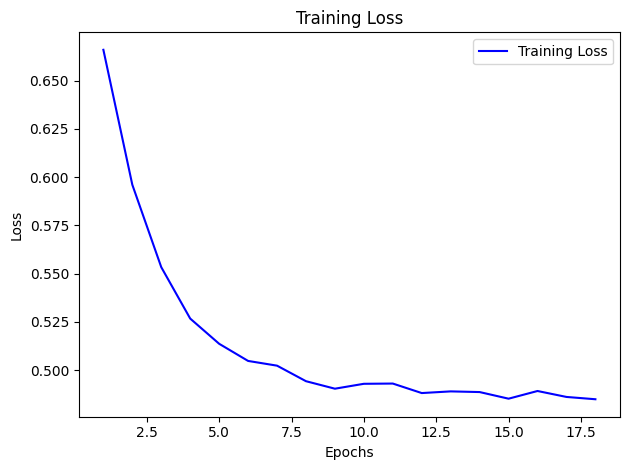

In [124]:
import matplotlib.pyplot as plt

train_loss = ae.metrics['train_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Variational Autoencoder:**

### Model:

In [128]:
class VariationalAutoencoder(pl.LightningModule):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        self.fc_mu = nn.Linear(512 * 2 * 2, 128)
        self.fc_logvar = nn.Linear(512 * 2 * 2, 128)
        self.fc_decoder_input = nn.Linear(128, 512 * 2 * 2)

        self.step_metrics = {"train_loss": []}
        self.metrics = {"train_loss": []}

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mean, logvar):
        var = torch.exp(logvar)
        std = torch.sqrt(var)
        random_normal = torch.randn_like(mean)
        return random_normal * std + mean

    def decode(self, z):
        z = self.fc_decoder_input(z)
        z = z.view(z.size(0), 512, 2, 2)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar

    def training_step(self, batch, batch_idx):
        x, _ = batch
        output, mu, logvar = self(x)

        reconstruction_loss = nn.functional.binary_cross_entropy(output, x, reduction='sum') / x.size(0)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1), dim=0)
        loss = reconstruction_loss + kld_loss

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.step_metrics["train_loss"].append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def on_train_epoch_end(self):
        for key, values in self.step_metrics.items():
            self.metrics[key].append(torch.mean(torch.tensor(values)).item())
            self.step_metrics[key] = []

vae = VariationalAutoencoder()

### Callback:

In [129]:
early_stopping = EarlyStopping(
            monitor='train_loss',
            min_delta=10,
            patience=10,
            verbose=True,
            mode='min'
)

### Training:

In [130]:
trainer = pl.Trainer(max_epochs=50, callbacks=[early_stopping], log_every_n_steps=1)
trainer.fit(vae, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | encoder          | Sequential | 1.6 M  | train
1 | decoder          | Sequential | 1.6 M  | train
2 | fc_mu            | Linear     | 262 K  | train
3 | fc_logvar        | Linear     | 262 K  | train
4 | fc_decoder_input | Linear     | 264 K  | train
--------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.751    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 7636.512
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 632.406 >= min_delta = 10. New best score: 7004.106
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 97.669 >= min_delta = 10. New best score: 6906.438
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 131.546 >= min_delta = 10. New best score: 6774.892
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 39.316 >= min_delta = 10. New best score: 6735.575
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 36.611 >= min_delta = 10. New best score: 6698.964
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 60.129 >= min_delta = 10. New best score: 6638.834
INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 10.474 >= min_delta = 10. New best score: 662

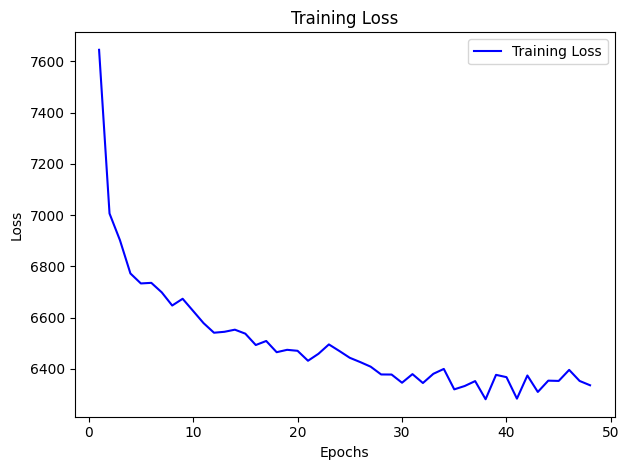

In [131]:
train_loss = vae.metrics['train_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Reconstruction Test:

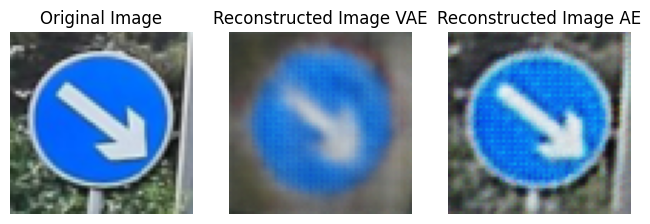

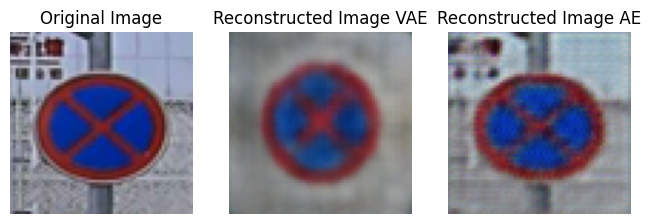

In [152]:
from PIL import Image

def load_and_preprocess_image(image_path: Path, transform: transforms.Compose) -> torch.Tensor:
    image = Image.open(image_path).convert('RGB')
    image_transformed = transform(image)
    return torch.unsqueeze(image_transformed, 0)

def reconstruct_image(image_path: Path, transform: transforms.Compose) -> None:
    image = load_and_preprocess_image(image_path, transform)

    with torch.no_grad():
        reconstruction_ae = ae(image)
        reconstruction_vae = vae(image)[0]

    original_img = image.squeeze(0).permute(1, 2, 0).numpy()
    reconstructed_img_ae = reconstruction_ae.squeeze(0).permute(1, 2, 0).numpy()
    reconstructed_img_vae = reconstruction_vae.squeeze(0).permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(8, 4))
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(reconstructed_img_vae)
    axes[1].set_title('Reconstructed Image VAE')
    axes[1].axis('off')
    axes[2].imshow(reconstructed_img_ae)
    axes[2].set_title('Reconstructed Image AE')
    axes[2].axis('off')
    plt.show()


ae.eval()
vae.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

image_path = dataset_path / "Test"/ "026_1_0007_1_j.png"
image_path_2 = dataset_path / "Test"/ "054_1_0011_1_j.png"

reconstruct_image(image_path, transform)
reconstruct_image(image_path_2, transform)